### Importing Dependencies

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import keras

In [9]:
import pickle

def load_set(directory):
    try:
        with open(f"{directory}/texts.pkl", "rb") as fp:
            processed_texts = pickle.load(fp)
        
        with open(f"{directory}/labels.pkl", "rb") as fp:
            labels = pickle.load(fp)
    
    except:
        print(f'{directory} files not found. Please run the preprocess.ipynb before!')
    
    return processed_texts, labels

In [10]:
processed_texts, labels = load_set('train')
processed_val_texts, val_labels = load_set('val')
processed_test_texts, test_labels = load_set('test')

In [11]:
processed_texts[:5]

["antidepressant free U.S???I'm México antidepressant cheap plus buy recipe anyways go psychiatrist prescribe medicine anxiety miraculous feel good life course go psychotherapist wonder expensive U.S cause México cheap know suffer long cure right pretty solid price",
 'buddys dad get fire want teach online friend dad fire teaching Nd job tell teach class online need large family immunocompromise covid huge risk petitioner set help job single person help greatly appreciate https://www.change.org/p/ltisd-administrators-save-schmidt',
 'attempt SuicideLast week decide 5000 mg 5 Grams Zoloft 20 mg Klonopin take hesitant find weird time attempt suicide hesitant scared time calm scared surprised wake find alive think dosage kill read people overdose die take know use think commit suicide attempt prove wrong time bit scared fear keep alive fear go feel like life movement hesitation er end vomit sleep recall vomit sleep effect overdose vomiting day take sleep',
 'grandpa die covid tell friend 

In [12]:
lengths = [len(processed_text) for processed_text in processed_texts if len(processed_text) < 2000]

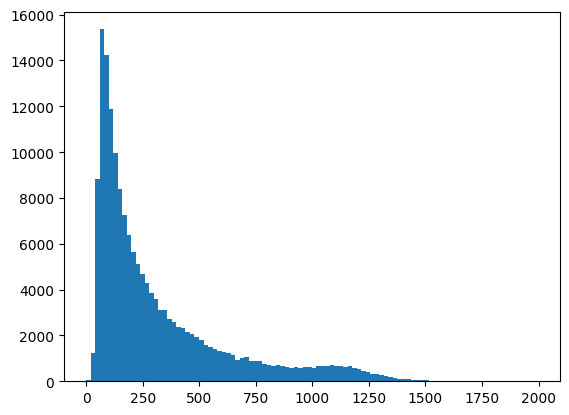

In [13]:
plt.hist(lengths, bins=100)
plt.show()

### Creating the Model

#### Vectorization

In [14]:
TextVectorization = keras.layers.TextVectorization

vectorize_layer = TextVectorization(
    max_tokens=3000,
    output_mode='int',
    output_sequence_length=200,
)

vectorize_layer.adapt(processed_texts + processed_val_texts)

In [15]:
vectorized_texts = vectorize_layer(processed_texts)

In [16]:
vectorized_val_texts = vectorize_layer(processed_val_texts)

#### Model 1

In [19]:
from keras_tuner import HyperParameters as hp
Sequential = keras.models.Sequential

model = Sequential([
    keras.layers.Embedding(3001, 16),
    keras.layers.SimpleRNN(64, return_sequences=True),
    keras.layers.SimpleRNN(64),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [20]:
model.fit(vectorized_texts, labels, epochs=10, validation_data=(vectorized_val_texts, val_labels), callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
    ])

Epoch 1/10
5229/5229 ━━━━━━━━━━━━━━━━━━━━ 142s 27ms/step - accuracy: 0.5639 - loss: 0.6864 - val_accuracy: 0.5727 - val_loss: 0.6825
Epoch 2/10
4284/5229 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - accuracy: 0.5662 - loss: 0.6851

##### Evaluating the Model

In [ ]:
vectorized_test_texts = vectorize_layer(processed_test_texts)

#### Saving the Model

In [ ]:
best_model = model
with open('./models/simple_rnn', 'wb') as fp:
    pickle.dump(model, fp)

In [ ]:
best_model.summary()
_ = best_model.evaluate(vectorized_test_texts, test_labels)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 200, 16)        │        48,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 200, 20)        │           740 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,793 (581.23 KB)

 Trainable params: 49,597 (193.74 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 99,196 (387.49 KB)

726/726 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6670 - loss: 0.6310


In [ ]:
y_pred = best_model.predict(vectorized_test_texts)
y_pred = (y_pred > 0.5).astype(int)
y_pred = np.array(list(map(lambda x: x[0], y_pred)))

726/726 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

tn, fp, fn, tp = confusion_matrix(test_labels, y_pred).ravel()

fpr = fp / (fp + tn)
print(f"False Positive Rate: {fpr:.4f}")

fnr = fn / (fn + tp)
print(f"False Negative Rate: {fnr:.4f}")

print(f'accuracy_score {accuracy_score(test_labels, y_pred):.3f}')
print(f'precision_score {precision_score(test_labels, y_pred):.3f}')
print(f'recall_score {recall_score(test_labels, y_pred):.3f}')
print(f'f1_score {f1_score(test_labels, y_pred):.3f}')

False Positive Rate: 0.4185
False Negative Rate: 0.2350
accuracy_score 0.672
precision_score 0.643
recall_score 0.765
f1_score 0.698


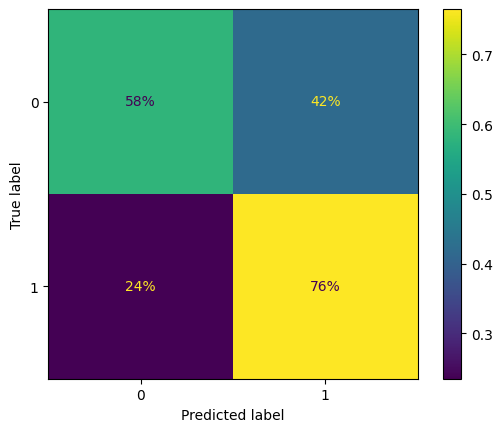

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(test_labels, y_pred, normalize="true",
                                        values_format=".0%")
plt.show()